In [1]:
import sys
sys.path.append('../')
import numpy as np
import importlib
import dataloader as u
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
import scipy.stats as stats

In [44]:
def smooth_timeseries(t, size=5, axis=0):
    '''Smooth the function by taking a moving average of "size" time steps'''
    average_filter = np.full((size, ), 1 / size)

    t = np.pad(t, [(size // 2 + (not size % 2), size // 2)], mode='median', stat_length=size)
    return np.apply_along_axis(lambda r: np.convolve(r, average_filter, mode='valid'), 
        axis=axis, arr=t)

In [45]:
datadict = u.load_covid_timeseries(smoothing=3, cases_cutoff=5)
cases = datadict['cases_raw']
deaths = datadict['deaths_raw']

In [46]:
demographics = u.load_demographics_data()
pop = demographics['total_pop']

In [937]:
county = 1879
z = deaths[county] 
z = z[z != 0]
init = [z[0]]
z1 = np.diff(z)
init.append(z1[0])
z2 = np.diff(z1)
print(z1)

[  1.   0.   0.   4.   2.   3.   1.   0.   7.   2.   0.  15.   3.   4.
   9.  16.  15.  12.  79.   0.  62.  29.  62.  41.  56.  44.  60.  51.
  37.  46.  43.   0.   0. 139.  42.  31.  41.  35.  41.  50.  30.  32.
  32.  26.  23.  24.  25.  32.  16.  22. 227.  25.  17.  31.  20.  22.
  15.  25.  16.]


In [938]:
z_smooth = smooth_timeseries(z1, 9)

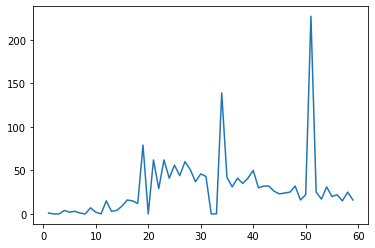

In [939]:
y = z1
x = np.linspace(1, y.shape[0], y.shape[0])
plt.plot(x, y)

In [940]:
dat = z_smooth

validation_steps = 5

X_train = np.arange(dat.shape[0] - validation_steps)
y_train = dat[:dat.shape[0] - validation_steps]

X_test = np.arange(dat.shape[0] - validation_steps, dat.shape[0])
y_test = dat[dat.shape[0] - validation_steps:]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(54,) (54,) (5,) (5,)


In [941]:
print(X_train, y_train)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53] [ 1.22222222  1.44444444  1.44444444  1.33333333  2.          2.11111111
  2.11111111  3.77777778  3.66666667  3.88888889  4.55555556  6.22222222
  7.88888889  8.44444444 17.         17.         22.22222222 25.11111111
 31.55555556 35.11111111 39.55555556 42.77777778 48.11111111 45.
 49.11111111 47.33333333 48.88888889 42.         37.44444444 46.66666667
 46.44444444 43.22222222 42.11111111 41.88888889 41.33333333 42.11111111
 45.44444444 49.         37.11111111 35.33333333 34.44444444 32.55555556
 31.44444444 30.44444444 26.66666667 25.77777778 47.44444444 46.66666667
 45.66666667 46.55555556 46.11111111 45.77777778 43.88888889 44.88888889]


In [942]:
def erf_model(x, max_val, loc, scale):
    return max_val*(1 + scipy.special.erf(scale*(x - loc)))

def skew_model(x, max_val, loc, scale, a, shift):
    return max_val * stats.skewnorm.pdf(x, a, loc, scale) + shift

def exp_model(x, max_val, loc, scale, K):
    return max_val*stats.exponnorm.pdf(x, K, loc, scale)

def exp_modelcdf(x, max_val, loc, scale, K):
    return max_val*stats.exponnorm.cdf(x, K, loc, scale)

erf_bounds = ([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf])
other_bounds = ([z.max(), 0, 0, 0], [100*z.max(), np.inf, np.inf, 10])

model = exp_model
bounds = other_bounds
popt, pcov = curve_fit(model, X_train, y_train, bounds=bounds)

In [943]:
print(popt)

[3694.02895345   17.14777309    6.28131829   10.        ]


In [944]:
errors = np.sqrt(np.diag(pcov))
print(errors)

[751.81222405   0.89561637   0.9781897    4.09308285]


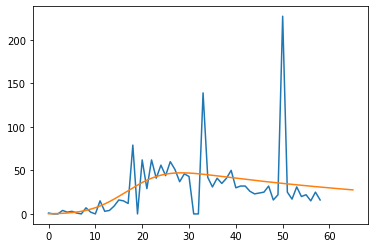

In [945]:
d = z1
x = np.linspace(0, d.shape[0] - 1, d.shape[0])
y = d
plt.plot(x, y)

x = np.linspace(0, 65, 1000)
y = exp_model(x, *popt)
# x = np.linspace(0, d.shape[0] + 19, d.shape[0] + 20)
# y = exp_modelcdf(x, *popt)
# y0 = [z[0]]
# y = np.concatenate([y0, np.diff(y)])
plt.plot(x, y)
#plt.plot(X_train, y_train, marker='o', linewidth=0)
#plt.plot(X_test, y_test, marker='o', linewidth=0)

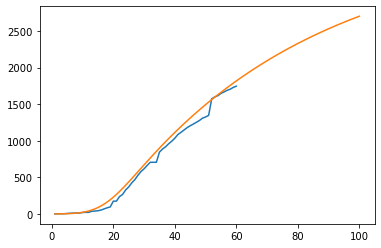

In [946]:
d = z
x = np.linspace(1, d.shape[0], d.shape[0])
y = d
plt.plot(x, y)

x = np.linspace(1, 100, 1000)
y = exp_modelcdf(x, *popt)
plt.plot(x, y)

In [947]:
d = z1
x = np.linspace(1, d.shape[0], d.shape[0])
y = model(x, *popt)

residuals = z1 - y
print(residuals)

[  0.71078886  -0.45208963  -0.69055978   2.96908274   0.49554493
   0.85333559  -1.99561502  -4.08944365   1.53699132  -5.14393109
  -9.14840995   3.52266039 -11.1133269  -13.01917941 -11.13829678
  -7.39715636 -11.70977889 -17.98374481  45.8729293  -36.05510389
  23.30341538 -11.99816236  19.07309361  -3.47066672  10.36354277
  -2.44728859  13.06196574   3.84904592 -10.13143581  -0.92437711
  -3.5714552  -46.10935955 -45.56892093  94.02502434  -2.34675957
 -12.69862416  -2.04089592  -7.3807438   -0.72296694   8.92934294
 -10.42572195  -7.78927805  -7.16193111 -12.54396864 -14.93548654
 -13.33646938 -11.74683949  -4.16648597 -19.59528119 -13.03308994
 192.52022569  -8.93519618 -16.3992185   -1.87170583 -12.35252467
  -9.84154349 -16.33863282  -5.84366519 -14.35651516]


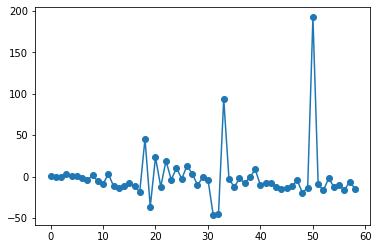

In [948]:
y = residuals
x = np.arange(0, y.shape[0])
plt.plot(x, y, marker='o')

In [949]:
val_steps = 20

In [950]:
train = residuals[:-val_steps]
test = residuals[-val_steps:]

orig_mse = np.sum(test*test) / test.shape[0]
print(orig_mse)

1987.041149846485


In [954]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train, seasonal_order=(2, 0, 1, 3))
model = model.fit()
predictions = model.forecast(val_steps)
print(predictions)
history = np.concatenate([train, predictions])

[ 2.81329101e+00  3.51062568e-01 -2.11301548e-01 -4.52112762e-01
 -2.37580852e-01  1.09998197e-02  1.35845977e-01  4.24536508e-02
 -6.95661214e-03 -3.07262979e-02 -1.20677099e-02  1.26200920e-03
  7.80971179e-03  2.78805653e-03 -3.56031969e-04 -1.88761521e-03
 -7.02010601e-04  8.24993213e-05  4.66051584e-04  1.70344764e-04]


In [955]:
predictions = np.array(predictions)
mse = np.sum((predictions - test)**2) / predictions.shape[0]
print(f'mse: {mse}')
print(f'improvement: {orig_mse - mse}')

mse: 1984.6803616314348
improvement: 2.3607882150502064


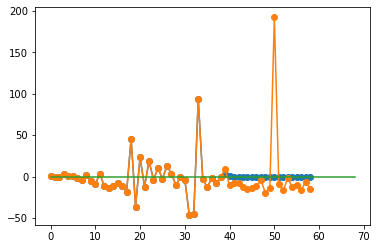

In [956]:
y = np.array(history)
x = np.arange(0, y.shape[0])
plt.plot(x, y, marker='o')

y = residuals
x = np.arange(0, y.shape[0])
plt.plot(x, y, marker='o')

y = np.zeros(y.shape[0] + 10)
x = np.arange(0, y.shape[0])
plt.plot(x, y)

In [958]:
series = residuals[:-val_steps]

In [959]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf

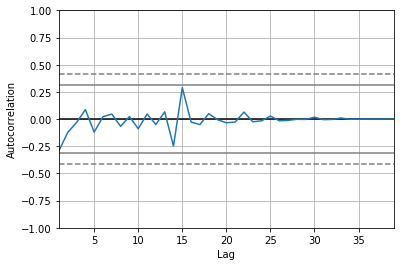

In [960]:
s = pd.Series(series)
autocorrelation_plot(s)

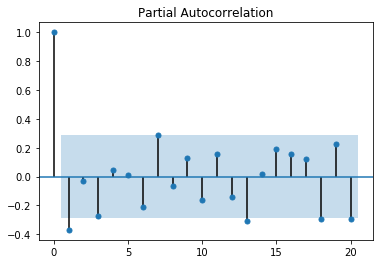

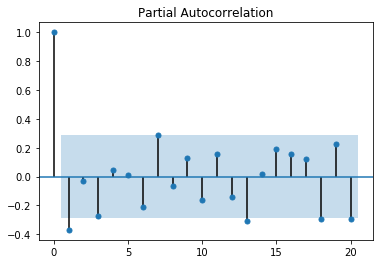

In [863]:
plot_pacf(s, lags=20)